# AVA Standardization Notebook
---
---

# Table of contents
1. [PRE-PROCESSING](#preprocess)
    1. [Select post-2010 data](#post2010)
    2. [Select Alaskan tundra data](#aktundra)
    3. [Access data](#dataaccess)
        1. [Auxiliary data](#auxdata)
        2. [Non-foliar fcover data](#nonfoliar)
        3. [Foliar fcover data](#foliar)
    4. [Join fcover to species checklist table](#joinchecklist)
    5. [Join fcover to leaf retention table](#joinleafretention)
    6. [Export species-PFT tables](#exporthabits)
    7. [Clean exported species-PFT tables](#cleanhabits)
2. [STANDARDIZATION](#standardization)
    1. [Standardize PFT names](#pftnames)
    2. [Sum species fcover to PFT-level](#sumfcover)
    3. [Standardize table layout](#tablelayout)
    4. [Standardize auxiliary columns](#aux)
        1. [Basic plot information](#basics)
        2. [Geographical intersections](#geo)
        3. [Duplicate coordinates](#dupes)
3. [EXPORT](#export)

# Load required packages

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import date
from pyogrio import read_dataframe
import glob
import geopandas as gpd
import sys
import os
import chardet
import regex as re

In [2]:
# import local functions
current_dir = os.path.abspath('..')
if current_dir not in sys.path:
    sys.path.append(current_dir)
import standardize_pft_funcs as spf

---
---
# 1. Pre-processing <a name="preprocess"></a>
After visually inspecting each species-level fcover table for obvious errors, we saved the "cleaned" tables to a folder that we then standardized here.

In [3]:
source = 'ava'

In [4]:
# read .xlsx table data stored on local machine
data_path = f'input_data/ava_ancillary_data.xlsx'
data = read_dataframe(data_path)
data = data.tail(-1)
ava_points = gpd.GeoDataFrame(data, 
                              geometry=gpd.points_from_xy(data['Longitude (decimal degrees)'], 
                                                          data['Latitude (decimal degrees)']), 
                              crs='EPSG:4326')
ava_points.rename(columns={'Field releve number':'plotName'}, inplace=True)
ava_points['plotName'] = ava_points['plotName']
ava_points.index = ava_points['plotName']
na_values=[-9, -9.0, '-9', '-9.0', -1, '-1']
ava_points.replace(na_values, np.nan, inplace=True)

---
## 1.1. Select post-2010 data <a name="post2010"></a>
Context: In Zhang et al. (in preparation), plot data collected prior to 2010 was deemed too old for usage. The plot data collected prior to 2010 likely did not match satellite imagery from 2019 that was used in the project.

In [5]:
# function to extract year as an integer
def get_year(val):
    num = int(val)
    string = str(num)
    year = string[:4]
    return int(year)

# extract data collected after 2010
temp = ava_points.copy()
temp['surveyYear'] = temp['Date (yyyymmdd)'].apply(lambda x: get_year(x))
ava_points = temp[temp['surveyYear'] >= 2010]
print('Number of post-2010 plot points:', len(ava_points))

Number of post-2010 plot points: 382


---
## 1.2. Select Alaskan tundra data <a name="aktundra"></a>
In Zhang et al. (in preparation), the plot data was limited to those collected in the arctic tundra. The Alaska Tundra polygon here was derived from the CAVM bioclimate zones, clipped to Alaska, and re-projected to EPSG 4326. The polygons were accessed in 2023 from the Alaska Arctic Geoecological Atlas Circumpolar Arctic Vegetation Map (CAVM Team 2003) webpage [linked here](https://arcticatlas.geobotany.org/catalog/dataset/circumpolar-arctic-vegetation-map-cavm-team-2003).

In [6]:
# load the local shapefile using geopandas
path = '../etc/tundra_alaska_latlon/tundra_alaska_wgs84.shp'
ak_tundra = gpd.read_file(path)
print(f'Shapefile coordinate reference system is {ak_tundra.crs}')

# ensure point and tundra polygon crs's match
ava_points = ava_points.to_crs(ak_tundra.crs)

# clip points to study area
ava_points = ava_points.clip(ak_tundra)
print(f'Number of post-2010 plot points in Alaska tundra: {len(ava_points)}')

Shapefile coordinate reference system is EPSG:4326
Number of post-2010 plot points in Alaska tundra: 308


<Axes: >

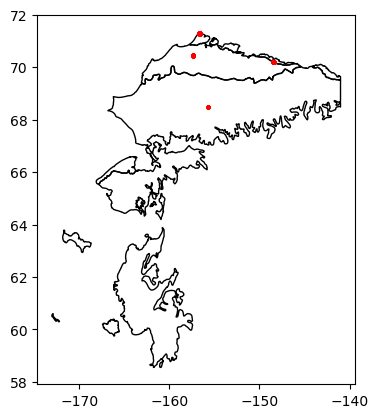

In [7]:
# plot the post-2010 alaskan tundra points
ax = ak_tundra.plot(edgecolor='black', facecolor='none')
ava_points.plot(ax=ax, color='red', markersize=3)

In [8]:
# export a list of the AVA datasets we will be harmonizing
ava_datasets = sorted(ava_points['Dataset'].unique())
print(ava_datasets)

['Atqasuk_Vera Komarkova (Komarkova and Webber 1980)', 'Barrow IBP Tundra Biome_Pat Webber (Webber 1978)', 'Barrow_DOE_NGEE_Victoria Sloan (Sloan et al. 2014)', 'Flux Tower Zona_Scott Davidson (Davidson et al. 2016)', 'Prudhoe ArcSEES road study_Donald Walker (Walker et al. 2015)', 'Prudhoe Bay Airport ArcSEES_Donald Walker (Walker et al. 2016)']


---
## 1.3. Access data  <a name="dataaccess"></a>

### 1.3.1. Auxiliary data  <a name="auxdata"></a>

In [9]:
# extract columns that DO NOT have "cover" in the name; this is auxiliary info
aux_cols = [col for col in ava_points.columns if 'Cover' not in col]
aux = ava_points[aux_cols].copy()

### 1.3.2. Non-foliar fcover data  <a name="nonfoliar"></a>

In [10]:
# extract columns with "cover" in the name; these contain the fcover data
cover_cols = [col for col in ava_points.columns if 'Cover' in col]
fcover = ava_points[cover_cols].copy()
fcover.drop(columns=['Cover abundance scale'], inplace=True) # not fcover

In [11]:
# extract non-vegetation fcover columns
etc = ['Cover bare soil (%)','Cover rock (%)','Cover water (%)']
non_veg = fcover[etc]
litter = fcover[['Cover litter (%)']]

# Remove the stuff we pulled out
etc.append('Cover litter (%)')
fcover.drop(columns=etc, inplace=True)

### 1.3.3. Foliar fcover data  <a name="foliar"></a>

In [12]:
# get paths to tables
species_csv_paths = sorted(glob.glob(f'input_data/ava_cover_tables/*.csv'))

In [13]:
# load tables in pandas; not all tables have known encoding
fcover_dfs = []
for path in species_csv_paths:
    with open(path, 'rb') as file:
        # dynamically detect file encoding because it is not consistent
        result = chardet.detect(file.read())
    df = pd.read_csv(path, encoding=result['encoding'], 
                     na_values=[-9, -9.0, '-9', '-9.0'])
    fcover_dfs.append(df)
fcover_dfs[3].head(3)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,11379,11380,11381,11382,11383,11384,11385,...,11421,11422,11423,11424,11425,11426,11427,11428,11429,11430
0,NaN,NaN,NaN,C1,C2-A,C2-B,C2-C,C3-A,C3-B,C4-A,...,LAVA-B,LAVA-C,QC25-A,QC25-B,QC35A,QC35-B,QC38-A,QC38-B,QC-45,QC-49
1,Aconitum delphinifolium [s. delphinifolium],Aconitum delphinifolium [s. delphinifolium] DC.,Aconitum delphinifolium s. delphinifolium,0,0,0,0,+,0,0,...,0,0,0,+,0,0,0,0,0,0
2,Alectoria ochroleuca,Alectoria ochroleuca (Hoffm.) Massal.,Alectoria ochroleuca,0,0,0,0,0,0,0,...,1,2,0,0,+,+,2,+,0,0


In [14]:
# get unique species names from ALL tables (not just post-2010)
species_names = []
for df in fcover_dfs: 
    names = df.iloc[:, 0] # first col without author
    for name in names:
        if pd.notnull(name):
            name = name.strip('[]')
            name = name.strip()
            species_names.append(name)
u_species_names = list(set(species_names))

# remove null species names
u_species_names = [x for x in u_species_names if pd.notnull(x)]
print(len(u_species_names))
species_names_df = pd.DataFrame(u_species_names, columns=['datasetSpeciesName'])

1847


---
## 1.4. Join fcover to species checklist table <a name="joinchecklist"></a>

In [15]:
# load species checklist and prep for joining
checklist_path = '../etc/akveg_species_checklist.csv'
checklist_df = spf.checklist_df(checklist_path)
checklist_df.head(3)

,nameCode,checklistSpeciesName,nameStatus,nameAccepted,nameFamily,acceptedNameSource,nameLevel,speciesForm,speciesHabit
0,abroth,Abrothallus De Not.,accepted,Abrothallus De Not.,Abrothallaceae,CNALH,genus,lichen,lichen
1,abrpar,Abrothallus parmeliarum (Sommerf.) Arnold,accepted,Abrothallus parmeliarum (Sommerf.) Arnold,Abrothallaceae,CNALH,species,lichen,lichen
2,abrpey,Abrothallus peyritschii (Stein) Kotte,accepted,Abrothallus peyritschii (Stein) Kotte,Abrothallaceae,Dillman et al. 2012,species,lichen,lichen


In [16]:
species_names_df.head(3)

,datasetSpeciesName
0,Agrostis mertensii
1,Sparganium natans
2,Arenaria humifusa


In [17]:
# get first 2 words (genus-species) from checklist accepted name and data species name
checklist_df['joinKey'] = checklist_df['checklistSpeciesName'].apply(spf.get_substrings)
species_names_df['joinKey'] = species_names_df['datasetSpeciesName'].apply(spf.get_substrings)
habits = spf.join_to_checklist(unique_species=species_names_df, 
                               checklist=checklist_df, 
                               u_name='datasetSpeciesName', 
                               c_unofficial_name='checklistSpeciesName', 
                               c_official_name='nameAccepted', 
                               mapping_name='joinKey',
                               habit='speciesHabit')
habits.head(3)

450 species are missing habits.
236 species still missing habits.
43 species still missing habits.
39 species still missing habits.


,datasetSpeciesName,joinKey,speciesHabit
index,,,
0,Agrostis mertensii,Agrostis mertensii,graminoid
1,Sparganium natans,Sparganium natans,forb
2,Arenaria humifusa,Arenaria humifusa,forb


In [18]:
species_names_df.head(3)

,datasetSpeciesName,joinKey
0,Agrostis mertensii,Agrostis mertensii
1,Sparganium natans,Sparganium natans
2,Arenaria humifusa,Arenaria humifusa


In [19]:
habits = species_names_df.merge(habits, how='left', left_on='datasetSpeciesName', right_on='datasetSpeciesName', suffixes=(None, '_1'))
habits = habits[['joinKey', 'datasetSpeciesName', 'speciesHabit']]

---
## 1.5. Join fcover to leaf retention table <a name="joinleafretention"></a>

In [20]:
# load leaf retention table and clean
path = '../etc/macander_leaf_retention.csv'
leaf_ret = spf.leaf_retention_df(path)
leaf_ret.head(3)

,leafRetention,retentionSpeciesName
0,deciduous,Salix
1,deciduous,Betula nana
2,deciduous,Vaccinium uliginosum


In [21]:
# add leaf retention column
habits_wleaf = spf.add_leaf_retention(habits, leaf_ret, 'leafRetention')
habits_wleaf = habits_wleaf[['datasetSpeciesName', 'joinKey', 'speciesHabit', 'leafRetention']]
habits_wleaf.head(3)

,datasetSpeciesName,joinKey,speciesHabit,leafRetention
0,Agrostis mertensii,Agrostis mertensii,graminoid,
1,Sparganium natans,Sparganium natans,forb,
2,Arenaria humifusa,Arenaria humifusa,forb,


In [22]:
# apply function
habits_wleaf['speciesHabit'] = habits_wleaf['speciesHabit'].apply(spf.clean_shrub_habits)
list(habits_wleaf['speciesHabit'].unique())

['graminoid',
 'forb',
 'moss',
 'spore-bearing',
 nan,
 'liverwort',
 'lichen',
 'shrub',
 'coniferous tree',
 'deciduous tree']

---
## 1.6. Export species-PFT tables <a name="exporthabits"></a>

In [23]:
# generate 3 files and dataframe of habit types
shrubs, nonshrubs, null = spf.export_habit_files(habits_wleaf,
                                                 'temp_data', 
                                                 source, 
                                                 'speciesHabit')

In [24]:
# check to make sure the files make sense
len(habits_wleaf) == (len(null) + len(nonshrubs) + len(shrubs))

True

---
## 1.7. Clean exported species-PFT tables <a name="cleanhabits"></a>
Here, we manually assessed each file. The nonshrubs were usually correct and did not have to be adjusted. Some shrubs were missing leaf retention information, so we consulted with arctic ecologists to determine it. For unknown (null) habits, we consulted arctic ecology expert, Amy Breen, to determine the issue and correct habit. After the tables were complete, all species names had a single associated habit.
- null habits
    - assign missing habits and consult ecologist when needed
- non-shrubs
    - assign leaf habit to all trees (ctrl-f to find all trees in excel)
        - coniferous tree = evergreen
        - deciduous tree  = deciduous
    - remove leaf habit if misapplied
- shrubs
    - check current leaf habits and correct if necessary
    - fill empty leaf habits
    - choose leaf habit if both evergreen & deciduous listed
    - add Stature column (dwarf shrub or not)

---
---
# 2. Standardization <a name="standardization"></a>

---
## 2.1. Standardize PFT names <a name="pftnames"></a>
deciduous shrub, evergreen shrub, graminoid, forb, litter, non-vascular (lichen, brophyte)

In [25]:
# paths to visually assessed and cleaned habit files
all_habit_types = [f'temp_data/{source}_nonshrubs_01.csv',
                   f'temp_data/{source}_shrubs_01.csv',
                   f'temp_data/{source}_nullhabit_01.csv']

# create list of habit dataframes
habit_dfs = []
for path in all_habit_types:
    habit_df = pd.read_csv(path, index_col=0)
    habit_dfs.append(habit_df)
all_habits = pd.concat(habit_dfs)

In [26]:
# show unique habit names we're working with
all_habits['speciesHabit'].unique().tolist()

['moss',
 'lichen',
 'forb',
 'graminoid',
 'liverwort',
 'spore-bearing',
 'deciduous tree',
 'coniferous tree',
 'shrub',
 'cyanobacteria',
 'algae',
 'bryophyte',
 'fungus',
 'crust']

In [27]:
# ava-specific habit name standardization function
def standardize_habit(habitrow, leafrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    new_row = []
    
    for habit, leaf in zip(habitrow, leafrow):
        
        habit = habit.lower()
        # non-shrubs
        if 'algae' in habit or 'cyanobacteria' in habit or 'crust' in habit:
            new_habit = 'other'
        elif habit == np.nan or 'unknown' in habit:
            new_habit = 'other'
        elif 'moss' in habit or 'liverwort' in habit:
            new_habit = 'bryophyte'
        elif 'spore-bearing' in habit:
            new_habit = 'forb'
        elif 'grass' in habit:
            new_habit = 'graminoid'
            
        # shrubs and trees
        elif 'shrub' in habit:
            new_habit = f'{leaf} shrub'
        elif 'tree' in habit:
            new_habit = f'{leaf} tree'
            
        else:
            new_habit = f'{habit}'
        new_row.append(new_habit)
    
    return new_row

In [28]:
# standardized PFT
standard_habit_col = standardize_habit(all_habits['speciesHabit'], 
                                       all_habits['leafRetention'])
all_habits['standardHabit'] = standard_habit_col
all_habits.rename(columns={'speciesHabit':'nonstandardHabit'}, inplace=True)
print(len(all_habits))
all_habits.head(3)

1847


,datasetSpeciesName,joinKey,nonstandardHabit,leafRetention,speciesStature,standardHabit
1515,Abietinella abietina,Abietinella abietina,moss,NaN,NaN,bryophyte
1420,Acarospora schleicheri,Acarospora schleicheri,lichen,NaN,NaN,lichen
971,Achillea lanulosa,Achillea lanulosa,forb,NaN,NaN,forb


---
## 2.2. Sum species fcover to PFT-level <a name="sumfcover"></a>

In [29]:
# ava-specific function to clean fcover values
from IPython.display import display, clear_output
import time
import pandas as pd
import numpy as np
import chardet
import os

def get_fcover_percent(paths, all_habits, habit_col, species_col):
    
    pft_fcover_tables = []
    species_fcover_tables = []  # New dataset with plotName, speciesNameNoAuth, percentCover columns
    
    cover_types = []
    
    # get fcover type from filename
    basenames = [os.path.basename(path) for path in paths]
    for name in basenames:
        cover_type = name.split('_')[-2]
        cover_types.append(cover_type)
    all_habits = all_habits[[species_col, habit_col]]
    
    # loop through each fcover table
    for path, cover_type in zip(paths, cover_types):

        # read table
        with open(path, 'rb') as file:
            result = chardet.detect(file.read())
            df = pd.read_csv(path, encoding=result['encoding'], 
                             header=1, 
                             na_values=[-9, -9.0, '-9', '-9.0'])
        clear_output(wait=True)
        display(habit_col, path)
        time.sleep(1)

        # rename columns
        cols = df.columns.to_numpy()
        cols[0] = 'speciesNameNoAuth'
        cols[1] = 'speciesNameAccepted'
        cols[2] = 'speciesName'
        df.columns = cols

        # get list of plot IDs
        plot_id_cols = df.columns.to_list()[3:]

        # get associated habit for each species
        df = df.merge(all_habits, left_on='speciesNameNoAuth', right_on=species_col)

        # br-bq to percentage conversion dict
        # Wood 2013. EFFECTS OF PRESCRIBED BURNING ON GRASSLAND AVIFAUNA AT RIVERLANDS MIGRATORY BIRD SANCTUARY
        bb_dict = {'r': 0.05, '+': 0.55, '1': 3.0, '2': 15.0, '3': 37.5, '4': 62.5, '5': 87.5, '-9': np.nan}
        # Westoff converstion dict
        wv_dict = {'1': 0.05, '2': 1.0, '3': 2.5, '4': 4.5, '5': 9.0, '6': 18.5, '7': 37.0, '8': 62.0, '9': 87.5}
        # Hult-Serander conversion dict
        hs_dict = {'+': 0.5, '1': 4.0, '2': 9.0, '3': 18.0, '4': 38.0, '5': 63.0, '6': 87.0}

        # convert wv codes
        if cover_type == 'wv':

            # replace westoff-van den maarel code with percentage
            cols = df.columns.to_list()
            df = df.astype(str)
            for col in cols:
                df.replace({col: wv_dict}, inplace=True)

        # covert br-bl codes        
        elif cover_type == 'brbl':

            # replace br-bl code with percentage
            cols = df.columns.to_list()
            df = df.astype(str)
            for col in cols:
                df.replace({col: bb_dict}, inplace=True)

        elif cover_type == 'hs':

            # replace hs code with percentage
            cols = df.columns.to_list()
            df = df.astype(str)
            for col in cols:
                df.replace({col: hs_dict}, inplace=True)

        # if already percent
        else:

            df = df.astype(str)

        # clean % data
        fcover = df.drop(columns=['speciesNameNoAuth', 'speciesNameAccepted', 'speciesName', species_col])
        fcover = fcover.loc[:, fcover.columns != habit_col].replace(' ', '0', regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].replace('', '0', regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].replace('\*', '0', regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].astype(float)

        # add back the standard habit column
        fcover = fcover.copy()
        fcover[habit_col] = df[habit_col] # replace codes with new fcover %

        # loop through each plot and sum fcover per pft
        pft_fcover = fcover.groupby(by=[habit_col]).sum().T
        pft_fcover.index = plot_id_cols
        pft_fcover['fcoverScale'] = cover_type
        pft_fcover_tables.append(pft_fcover)
        
        # Reshape the dataset to match the desired structure
        df_melted = df.melt(id_vars=['speciesNameNoAuth'], value_vars=plot_id_cols, var_name='plotName', value_name='percentCover')
        
        # Replace problematic values and convert percentCover to float
        df_melted['percentCover'] = pd.to_numeric(df_melted['percentCover'], errors='coerce').fillna(np.nan)
        
        species_fcover_tables.append(df_melted[['plotName', 'speciesNameNoAuth', 'percentCover']])
    
    return pft_fcover_tables, species_fcover_tables

In [30]:
# this section is working on ALL plot data
pft_fcover_dfs, species_fcover_dfs = get_fcover_percent(species_csv_paths, all_habits, 
                                                        'standardHabit', 'datasetSpeciesName')

'standardHabit'

'input_data/ava_cover_tables/aava_willows_uschickhoff_2002_spp_brbl_modsrc.csv'

In [31]:
# add accepted name and standard habit to species level fcover
all_habits = all_habits[['datasetSpeciesName', 'standardHabit', 'nonstandardHabit']]
species_fcover = pd.concat(species_fcover_dfs)
species_fcover = species_fcover.rename(columns={'speciesNameNoAuth':'datasetSpeciesName'})
species_fcover

,plotName,datasetSpeciesName,percentCover
0,BELA_T01_02_2002,Abietinella abietina,0.00
1,BELA_T01_02_2002,Aconogonon alaskanum,0.00
2,BELA_T01_02_2002,Adoxa moschatellina,0.00
3,BELA_T01_02_2002,Agonimia tristicula,0.00
4,BELA_T01_02_2002,Agrostis scabra,0.00
...,...,...,...
18270,85,Vaccinium vitis-idaea s. minus,0.00
18271,85,Valeriana capitata,0.00
18272,85,Viola epipsila s. repens,0.00
18273,85,Vulpicida tilesii,0.55


In [32]:
species_fcover = species_fcover.merge(all_habits, 
                                      left_on='datasetSpeciesName', 
                                      right_on='datasetSpeciesName')
species_fcover = species_fcover[species_fcover['percentCover'].notna() & (species_fcover['percentCover'] != 0)]
species_fcover = species_fcover[['plotName', 'datasetSpeciesName', 'standardHabit', 
                                 'nonstandardHabit', 'percentCover']]
species_fcover['standardHabit'] = species_fcover['standardHabit'].replace('fungus', 'other')
species_fcover.head(3)

,plotName,datasetSpeciesName,standardHabit,nonstandardHabit,percentCover
936,BELA_T01_02_2002,Wilhelmsia physodes,forb,forb,0.1
996,BELA_T01_03_2002,Artemisia tilesii,forb,forb,1.0
1141,BELA_T01_03_2002,Castilleja caudata,forb,forb,0.1


In [33]:
species_fcover.to_csv(f'output_data/{source}_nonstandard_species_fcover.csv', index=False)

---
## 2.3. Standardize table layout <a name="tablelayout"></a>

In [34]:
pft_fcover = pd.concat(pft_fcover_dfs)

In [35]:
# list of necessary PFTs
pfts = ['deciduous shrub', 'deciduous tree',
        'evergreen shrub', 'evergreen tree',
        'forb', 'graminoid', 'non-vascular',
        'bryophyte', 'lichen', 'litter', 'other']

In [36]:
# add litter
litter = litter.copy()
litter.rename(columns={'Cover litter (%)': 'litter'}, inplace=True)
pft_fcover = litter.merge(pft_fcover, how='left', left_index=True, right_index=True)

In [37]:
# create non-vascular
pft_fcover['non-vascular'] = pft_fcover['bryophyte'] + pft_fcover['lichen']

In [38]:
# create standard columns
pft_fcover = spf.add_standard_cols(pft_fcover, pfts)
pft_fcover = pft_fcover[pfts]
pft_fcover.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,other
plotName,,,,,,,,,,,
T5-025-T,1.10,NaN,0.0,NaN,0.55,75.00,6.55,6.55,0.0,NaN,NaN
T5-025-C,21.00,NaN,0.0,NaN,3.55,67.15,39.30,39.30,0.0,NaN,NaN
T5-050-T-B,0.55,NaN,0.0,NaN,0.55,3.55,87.05,87.05,0.0,NaN,NaN


In [39]:
# add non-vegetation
non_veg = non_veg.rename(columns={'Cover bare soil (%)':'bare ground',
                       'Cover rock (%)':'bare ground',
                       'Cover water (%)':'water'})
non_veg = non_veg.groupby(lambda x:x, axis=1).sum()
pft_fcover = pft_fcover.merge(non_veg, how='left', left_index=True, right_index=True)
pft_fcover.head(3)

/tmp/ipykernel_2707010/3988488299.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  non_veg = non_veg.groupby(lambda x:x, axis=1).sum()


,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,other,bare ground,water
plotName,,,,,,,,,,,,,
T5-025-T,1.10,NaN,0.0,NaN,0.55,75.00,6.55,6.55,0.0,NaN,NaN,0.0,0.0
T5-025-C,21.00,NaN,0.0,NaN,3.55,67.15,39.30,39.30,0.0,NaN,NaN,5.0,0.0
T5-050-T-B,0.55,NaN,0.0,NaN,0.55,3.55,87.05,87.05,0.0,NaN,NaN,0.0,0.0


---
## 2.4. Standardize auxiliary columns <a name="aux"></a>

Plot information:
- [ ] UID
- [x] plotName
- [x] dataSource
- [x] dataSubsource
- [x] fcoverScale
- [x] surveyMethod
- [x] surveyPurpose
- [x] duplicatedCoords
- [x] duplicatedDate
- [x] surveyYear
- [x] surveyMonth
- [x] surveyDay

Geographical information:
- [x] bioclimateSubzone
- [x] adminCountry
- [x] adminUnit
- [x] fireYears
- [x] coordEpsg
- [x] georefSource
- [x] georefAccuracy
- [x] plotRadius
- [x] longitueX
- [x] latitudeY

In [40]:
# sampling methods, coverscale, data source
methods_path = '../etc/sampling_methods.csv'
methods = pd.read_csv(methods_path)

### 2.4.1. Basic plot information <a name="basics"></a>

In [41]:
def extract_datetime(val):
    num = int(val)
    string = str(num)
    if len(string) == 8:
        year = string[0:4]
        month = string[4:6]
        day = string[6:8]
    elif len(string) == 6:
        year = string[0:4]
        month = string[4:6]
        day = np.nan
    elif len(string) == 4:
        year = string[0:4]
        month = np.nan
        day = np.nan   
    else:
        year = np.nan
        month = np.nan
        day = np.nan      
    return year, month, day

In [42]:
aux['Releve shape'].unique()

array(['square', 'linear/band-forming', 'irregular'], dtype=object)

In [43]:
new_aux = pd.DataFrame()

# date columns
new_aux[['surveyYear', 'surveyMonth', 'surveyDay']] = aux['Date (yyyymmdd)'].apply(extract_datetime).apply(pd.Series)

# plot size
aux['Releve area (m2)'].replace(-1, np.NaN)

# Calculate plotArea and adjust plotShape
def calculate_plot_size(row):
    try:
        area = float(row['Releve area (m2)']) if pd.notna(row['Releve area (m2)']) else np.NaN
    except ValueError:
        return row  # Return the row as-is if casting fails
    
    shape = row['Releve shape']
    
    if pd.isna(area):
        row['plotShape'] = shape if pd.notna(shape) else np.NaN
        row['plotArea'] = np.NaN  # Handle NaN area
    else:
        row['plotArea'] = area  # Always store area in plotArea
        
        # Determine the shape based on the provided value
        if shape == 'circle':
            row['plotShape'] = 'circle'
        elif shape == 'square':
            row['plotShape'] = 'square'
        else:
            row['plotShape'] = shape
    
    return row

# Apply calculations and update columns
updated_aux = aux.apply(calculate_plot_size, axis=1)

# Extract and assign the final columns
new_aux['plotArea'] = updated_aux['plotArea']
new_aux['plotShape'] = updated_aux['plotShape']

# geographical information
new_aux['latitudeY'] = aux['Latitude (decimal degrees)']
new_aux['longitudeX'] = aux['Longitude (decimal degrees)']
new_aux['georefSource'] = aux['Georeference source']
new_aux['georefAccuracy'] = aux['Georeference accuracy (m)'].astype('Float32')
new_aux['coordEPSG'] = 'EPSG:4326'

# main
new_aux['plotName'] = aux['plotName']
new_aux['dataSubsource'] = aux['Dataset'].apply(lambda name: name.replace('_', ' '))
new_aux['dataSubsource'] = new_aux['dataSubsource'].apply(lambda name: re.sub(r'\([^)]*\)', '', name))
new_aux['dataSubsource'] = new_aux['dataSubsource'].apply(lambda name: name.strip())

In [44]:
new_aux['plotShape'].unique()

array(['square', 'linear/band-forming', 'irregular'], dtype=object)

In [45]:
# adjust data subsource names
new_aux['dataSubsource'].replace({'Prudhoe Bay Airport ArcSEES Donald Walker':'Prudhoe Bay Airport ArcSEES Walker (pub 2016)',
                                  'Prudhoe ArcSEES road study Donald Walker':'Prudhoe ArcSEES road study Walker (pub 2015)',
                                  'Flux Tower Zona Scott Davidson':'Flux Tower Zona Davidson (pub 2016)',
                                  'Barrow DOE NGEE Victoria Sloan':'Barrow DOE NGEE Sloan (pub 2014)',
                                  'Atqasuk Vera Komarkova':'Atqasuk Villarreal (pub 2013)',
                                  'Barrow IBP Tundra Biome Pat Webber':'Barrow IBP Tundra Biome Villarreal (pub 2012)'}, inplace=True)

/tmp/ipykernel_2707010/1816956801.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_aux['dataSubsource'].replace({'Prudhoe Bay Airport ArcSEES Donald Walker':'Prudhoe Bay Airport ArcSEES Walker (pub 2016)',


In [46]:
new_aux = new_aux.merge(methods, how='left', left_on='dataSubsource', right_on='dataSubsource')
new_aux = new_aux.set_index(new_aux['plotName'])

### 2.4.2. Geographical intersections <a name="geo"></a>

In [47]:
# set geo info
geo_paths = ['../etc/gaul1/gaul1_asap.shp',
             '../etc/fire/InterAgencyFirePerimeterHistory_All_Years_View.shp',
             '../etc/bioclim/bioclimate_la_latlon.shp']
geo_names = ['gaul1',
             'fire',
             'bioclim']
geo_cols = [['name1', 'name0', 'geometry'],
            ['FIRE_YEAR', 'geometry'],
            ['zone', 'geometry']]

In [48]:
# create geospatial information
fcover_epsg = 'EPSG:4326' # wgs 84
intersect_epsg = 'EPSG:5936' # alaska projected datum
fcover_and_aux = pd.concat([pft_fcover, new_aux], join='inner', axis=1)
fcover_and_aux = gpd.GeoDataFrame(fcover_and_aux, 
                                  geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'],
                                                              fcover_and_aux['latitudeY']),
                                  crs=fcover_epsg)
fcover_and_aux = fcover_and_aux.to_crs(intersect_epsg)

# add new geospatial intersections
fcover_and_aux = spf.add_geospatial_aux(fcover_and_aux, 
                                        geo_paths, 
                                        geo_names, 
                                        geo_cols,
                                        intersect_epsg)

# drop unneccesary columns
fcover_and_aux = fcover_and_aux.drop(columns=['index_gaul1', 
                                              'index_fire', 
                                              'index_bioclim', 
                                              'plotName'])

In [49]:
# rename new columns
fcover_and_aux.rename(columns={'name1':'adminUnit',
                               'name0':'adminCountry',
                               'FIRE_YEAR':'fireYears',
                               'zone':'bioclimSubzone'}, inplace=True)

### 2.4.3. Duplicate coordinates <a name="dupes"></a>
This indicates that plots may have been revisited, they were very close and GPS accuracy was too low, or there is human error

In [50]:
# duplicate coord column
coords = ['longitudeX', 'latitudeY']
fcover_and_aux['duplicatedCoords'] = np.nan
fcover_and_aux = spf.find_duplicates(fcover_and_aux, coords, 'duplicatedCoords')

# duplicate date column
date = ['surveyYear', 'surveyMonth', 'surveyDay']
fcover_and_aux['duplicatedDate'] = np.nan
fcover_and_aux = spf.find_duplicates(fcover_and_aux, date, 'duplicatedDate')

duplicates found
duplicates found


---
# 3. Export <a name="export"></a>

In [51]:
# clean up
pfts = {'deciduous shrub':'deciduousShrubCover',
        'evergreen shrub':'evergreenShrubCover',
        'deciduous tree':'deciduousTreeCover',
        'evergreen tree':'evergreenTreeCover',
        'forb':'forbCover',
        'graminoid':'graminoidCover',
        'non-vascular':'nonvascularSumCover',
        'bryophyte':'bryophyteCover',
        'lichen':'lichenCover',
        'litter':'litterCover',
        'bare ground':'baregroundCover',
        'water':'waterCover',
        'other':'otherCover'}

# rename columns
fcover_and_aux.rename(columns=pfts, inplace=True)
fcover_cols = list(pfts.values())

# reproject and set cover data type
fcover_and_aux = fcover_and_aux.to_crs('EPSG:4326')
fcover_and_aux[fcover_cols] = fcover_and_aux[fcover_cols].astype(np.float32)
fcover_and_aux.index.name = 'plotName'

In [52]:
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'otherCover', 'baregroundCover', 'waterCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'geometry', 'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone',
       'duplicatedCoords', 'duplicatedDate'],
      dtype='object')

In [53]:
# Export cover data
covercols = [col for col in fcover_and_aux.columns if 'Cover' in col]
auxcols = [col for col in fcover_and_aux.columns if 'Cover' not in col]
pft_fcover = fcover_and_aux[covercols]
pft_fcover.to_csv(f'output_data/{source}_standard_pft_fcover.csv')

# Export aux data
pft_aux = fcover_and_aux[auxcols]
pft_aux.to_csv(f'output_data/{source}_plot_info.csv')